# Task 2: Graph Property Prediction
## (b) Classification Experiments

### Setup
Setup TUDataset environment and generate kernels as shown in the provided `generate_kernels.ipynb` notebook.

In [1]:
%%capture
!git clone https://github.com/chrsmrrs/tudataset.git

%pip --no-cache-dir install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-geometric

%pip --no-cache-dir install pybind11
!sudo apt-get install libeigen3-dev

%cd ../content/tudataset/tud_benchmark/kernel_baselines/
!g++ -I /usr/include/eigen3 -O3 -shared -std=c++11 -fPIC `python3 -m pybind11 --includes`  kernel_baselines.cpp src/*cpp -o ../kernel_baselines`python3-config --extension-suffix`
%cd ..

In [2]:
import os
import torch
import numpy as np
import kernel_baselines as kb
import auxiliarymethods
import auxiliarymethods.auxiliary_methods as aux
import auxiliarymethods.datasets as dp
import auxiliarymethods.kernel_evaluation as ke
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [3]:
dataset = 'IMDB-BINARY'
use_labels = False
use_edge_labels = False

os.makedirs('kernels/without_labels', exist_ok=True)
classes = dp.get_dataset(dataset)

### Comparing the baseline graph kernels

Our clustering algorithm was able to produce the best results on the Weisfeiler-Lehman 1 kernel using feature vectors. When applying the support vector classifier on the data, this trend continued:

In [6]:
def print_evaluation(title, features, linear=False):
    num_reps = 10
    evaluation = ke.linear_svm_evaluation if linear else ke.kernel_svm_evaluation
    accuracy, std_10, std_100 = evaluation(features, classes, num_repetitions=num_reps, all_std=True)
    print(f"{title} accuracy: {accuracy:.2f} (STD10: {std_10:.4f}, STD100: {std_100:4f})")

In [8]:
print("WL gram matrix")
for iterations in range(5):
    all_matrices = []
    for i in range(1, iterations+2):
        gm = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
        gm = aux.normalize_gram_matrix(gm)
        all_matrices.append(gm)
    print_evaluation(f"WL{iterations+1}", all_matrices)

WL gram matrix
WL1 accuracy: 73.10 (STD10: 0.6557, STD100: 3.940812)
WL2 accuracy: 72.79 (STD10: 0.8324, STD100: 4.377888)
WL3 accuracy: 72.26 (STD10: 0.7552, STD100: 4.559868)
WL4 accuracy: 72.29 (STD10: 0.7176, STD100: 4.350391)
WL5 accuracy: 72.60 (STD10: 0.9110, STD100: 4.787484)


In [9]:
print("WL feature vectors")
for iterations in range(5):
    feature_vectors = []

    for i in range(1, iterations+2):
        fv = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
        fv = aux.normalize_feature_vector(fv)
        feature_vectors.append(fv)
    print_evaluation(f"WL{iterations+1}", feature_vectors, linear=True)

WL feature vectors
WL1 accuracy: 72.91 (STD10: 0.6172, STD100: 4.600207)
WL2 accuracy: 72.62 (STD10: 0.7054, STD100: 3.905842)
WL3 accuracy: 72.50 (STD10: 0.8556, STD100: 4.205948)
WL4 accuracy: 72.12 (STD10: 0.7194, STD100: 3.973110)
WL5 accuracy: 71.90 (STD10: 0.6245, STD100: 3.945884)


The best classification performance was achieved for the single-iteration 
version of the kernel. Not only did more iterations not improve the results, they got ever so slightly worse. Underfitting could be one possible explanation for this behaviour, if the algorithm is not able to make use of the additional features due to the relatively small dataset of only 1000 points.

The different accuracies between the gram matrix and feature vector representations are negligible; however, the execution time on the sparse feature vectors is much lower. 

In [10]:
features = kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
features = [aux.normalize_gram_matrix(features)]
print_evaluation("Graphlet gram matrix", features)

features = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
features = [aux.normalize_feature_vector(features)]
print_evaluation("Graphlet feature vec", features, linear=True)

features = kb.compute_shortestpath_dense(dataset, use_labels)
features = [aux.normalize_gram_matrix(features)]
print_evaluation("Shortest gram matrix", features)

features = kb.compute_shortestpath_sparse(dataset, use_labels)
features = [aux.normalize_feature_vector(features)]
print_evaluation("Shortest feature vec", features, linear=True)

Graphlet gram matrix accuracy: 59.51 (STD10: 0.9914, STD100: 4.859002)
Graphlet feature vec accuracy: 59.58 (STD10: 0.6416, STD100: 5.044165)
Shortest gram matrix accuracy: 58.95 (STD10: 0.7632, STD100: 4.811185)
Shortest feature vec accuracy: 59.24 (STD10: 0.2800, STD100: 4.829327)


Both the Graphlet and the Shortest Path kernel exhibit significantly worse classification accuracy than WL. Differences between those four kernel representations are negligible.

### Cross Validation

The provided `kernel_svm_evaluation` function applies a 10-fold cross validation in order to fit the regularization hyperparameter $c$. Experimentation showed that the best values for $c$ were usually 10, 100 or 1000, with no discernable difference in performance, so we set the value to a constant 100 for the next steps to reduce complexity. 

In [11]:
gram_matrix = kb.compute_wl_1_dense(dataset, 1, False, False)
gram_matrix = aux.normalize_gram_matrix(gram_matrix)

accuracies = []
for train_index, val_index in KFold(n_splits=10, shuffle=True).split(classes):
    X_train = gram_matrix[train_index, :][:, train_index]
    X_val = gram_matrix[val_index, :][:, train_index]
    y_train = classes[train_index]
    y_val = classes[val_index]

    clf = SVC(C=100, kernel='precomputed', tol=0.001)
    clf.fit(X_train, y_train)

    accuracies.append(accuracy_score(y_val, clf.predict(X_val)))

print("cv accuracies:", accuracies)
print("mean:", np.array(accuracies).mean())

cv accuracies: [0.75, 0.8, 0.7, 0.76, 0.69, 0.74, 0.77, 0.73, 0.7, 0.71]
mean: 0.735


### Visualizing the Classification Results




In [14]:
def classify(gram_matrix, classes):
    index = np.arange(len(classes))
    train_index, test_index = train_test_split(index, test_size=0.3)

    X_train = gram_matrix[train_index, :][:, train_index]
    X_test = gram_matrix[test_index, :][:, train_index]
    y_train = classes[train_index]
    y_test = classes[test_index]

    clf = SVC(C=100, kernel='precomputed', tol=0.001)
    clf.fit(X_train, y_train)

    prediction = clf.predict(X_test)

    return prediction, y_test, test_index

In [31]:
def visualize(prediction, y_test, test_index):
    sorting = np.argsort(test_index)
    test_sorted = y_test[sorting].reshape(20, 15)
    prediction_sorted = prediction[sorting].reshape(20, 15)

    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].imshow(test_sorted)
    ax[1].imshow(prediction_sorted)
    ax[2].imshow(test_sorted != prediction_sorted, cmap='seismic')

    ax[0].set_title("true labels")
    ax[1].set_title("predicted labels")
    ax[2].set_title("misclassified")

    return fig

This plot shows the results the classification. Purple and yellow datapoints are the two labels (*romance* and *action*). Our best predictor (with an accuracy of about 73%, see above) behaves roughly the same for both labels: There is about the same amount of misclassification for each of the labels.

Text(0.5, 0.98, 'WL1 classification')

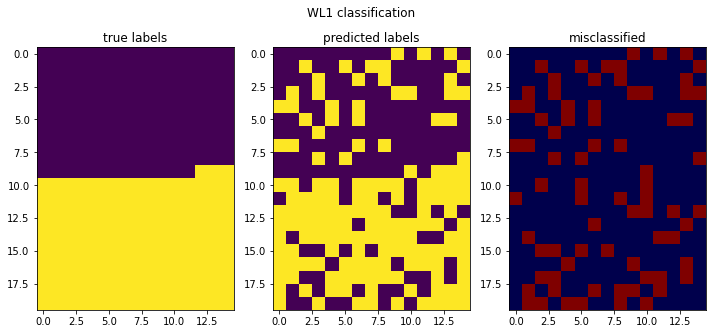

In [33]:
visualize(*classify(gram_matrix, classes)).suptitle("WL1 classification")

Classification on the Graphlet kernel, however, shows more misclassified points among (true) label 1 than (true) label 0. In terms of an SVM, the resulting hyperplane could not discriminate between the two clusters as well, and it "errs" on the side of label 0. 

Text(0.5, 0.98, 'Graphlet classification')

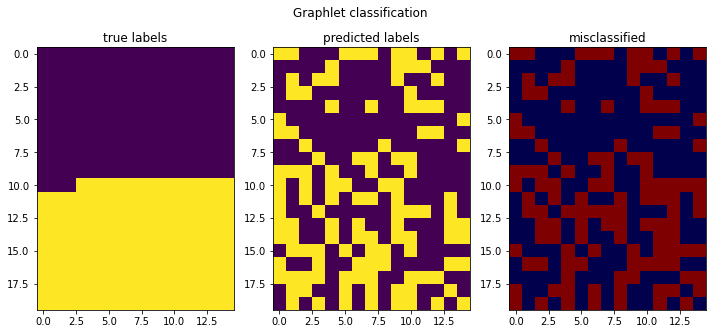

In [34]:
gram_matrix = kb.compute_graphlet_dense(dataset, False, False)
gram_matrix = aux.normalize_gram_matrix(gram_matrix)

visualize(*classify(gram_matrix, classes)).suptitle("Graphlet classification")